In [1]:
import os
import numpy as np
from janome.tokenizer import Tokenizer

t = Tokenizer()
data_dir = "../data/PriceIncreaseNews"
files = os.listdir(data_dir)

y = []
NewsList = []
for file in files:
    f = open(data_dir + '/' + file, 'r')
    next(f)
    for line in f:
        (stock_id, ratio, news) = line[:-1].split('\t')
        tokens = t.tokenize(news)
        token_list = [token.surface for token in tokens if token.part_of_speech.count("数詞") == 0]
        y.append(float(ratio))
        NewsList.append(news)
    f.close()
y = np.array(y)

def stems(text):
    token_list = [token.surface for token in t.tokenize(text) if token.part_of_speech.count("数") == 0]
    return set(token_list)

def accuracy(y_test, y_pred):
    t = 0.0
    f = 0.0
    for yi, yi_ in zip(y_test, y_pred):
        if(yi * yi_ > 0.0):
            t += 1.0
        else:
            f += 1.0
    return t/(t+f)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer(analyzer=stems, ngram_range=(1, 1))
count_vec = CountVectorizer(analyzer=stems, ngram_range=(1, 1))
X_tfidf = vectorizer.fit_transform(NewsList)
X_count = count_vec.fit_transform(NewsList)

alpha_list:  [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24, 20.48]


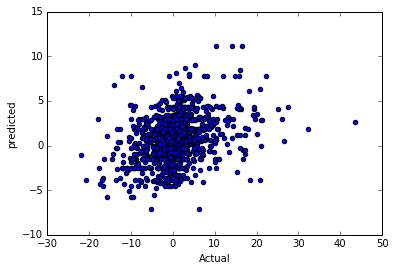

mse 36.3574841407
accuracy 0.622202327663384


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.cross_validation import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_count, y, test_size=0.2, random_state=1)
alpha_list =  [0.01 * pow(2, i) for i in range(12)]
print("alpha_list: ", alpha_list)
slr = RidgeCV(alphas = alpha_list)
#slr = RandomForestRegressor(criterion = 'mse')
slr.fit(X_train, y_train)

y_pred = slr.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.show()

print("mse", mse(y_test, y_pred))
print("accuracy", accuracy(y_test, y_pred))

In [4]:
coef_map = {term:coef for term, coef in zip(vectorizer.get_feature_names(), slr.coef_)}

In [5]:
print('=== 上位coef ===')
for c_tup in sorted(coef_map.items(), key=lambda x:x[1], reverse=True)[:25]:
    print(c_tup)
    
print('\n=== 下位coef ===')
for c_tup in sorted(coef_map.items(), key=lambda x:x[1], reverse=False)[:25]:
    print(c_tup)

=== 上位coef ===
('指定', 4.5387995603727962)
('ヤフー', 3.5966350160370721)
('替え', 3.2954925660539724)
('TOB', 3.1977711101254407)
('合意', 3.0165238174643925)
('解除', 2.976222063817906)
('ブロック', 2.9193997075789229)
('運用', 2.8624701842749527)
('新設', 2.8525045107256175)
('代理', 2.6896697006818218)
('実施', 2.5634968723159357)
('LINE', 2.56248283499853)
('販促', 2.5386510435560594)
('ポータルサイト', 2.531583835443735)
('生体', 2.5264352119733671)
('上方', 2.4954643041516582)
('医療', 2.4724982916123652)
('増配', 2.4699916905473782)
('スタジオ', 2.2286480977099141)
('工場', 2.1570298141968771)
('東証', 2.146368072621581)
('チェーン', 2.1315407508918565)
('提携', 2.0454854451603044)
('認証', 2.0233447005962324)
('イトーキ', 1.9647459406998431)

=== 下位coef ===
('規制', -3.9622782193976187)
('信用', -3.7211782366486661)
('下方', -3.3435725256673638)
('減配', -3.1720208895715842)
('変更', -2.6495634911131178)
('減益', -2.404047815689498)
('中', -2.3113119139982001)
('減', -2.1352163377072038)
('ステージ', -2.1149500474166176)
('売り出し', -2.0899934798156092)
(

In [6]:
print(slr.alpha_)

10.24
